[<< Previous: Model Fitting](03_rating_pred.ipynb)

# Results analysis

In this notebook, we will conduct some high-level analysis of our model's prediction behavior. We will again use the `R` language and `tidyverse` tools for this analysis.

First, let's import the libraries that will be required for this notebook.

In [1]:
library(tidyverse)
library(yaml)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Configurations

Before we do our analysis, let's make sure we are retrieving the prediction outputs for the appropriate experiment.

In [2]:
config_id <- "mlml6_rate_pred_clsp"
results_base <- paste0("../experiments/results/", config_id)

## Load results

Let's load in the results of our fitted model's test set predictons.

In [3]:
results_df <- read_csv(paste0(results_base, "/predictions_df.csv"))

Rows: 3310 Columns: 2
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): y, yhat

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Error metrics

Let's compute some error metrics. Notice that, for our grouped (summary) metrics, we round $y$ to the nearest $0.5$ and then group within that subset. This is an easy way to place observations of a continuous target variable into meaningful groups. In our dataset, the ratings are mentally rounded to the nearest $0.1$ already (no reviewers would give an album a $7.51$), but this is a rather small bin size and would be difficult to look at in a figure.

In [15]:
# What is the bin size we want to have for our groupings of y?
rnd_unit = 0.25

# Observation-level error metrics
error_df <- results_df %>%
    mutate(
        y_rnd = round(y / rnd_unit) * rnd_unit,
        se = (y - yhat)^2,
        bias = yhat - y
    )

# y bin-level error metrics
error_summary_df <- error_df %>%
    group_by(y_rnd) %>%
    summarize(
        mse = mean(se),
        rmse = sqrt(mse),
        bias_mean = mean(bias),
        bias_sd = sd(bias),
        n_obs = n()
    )

## Bias

We observed in our exploratory analysis that the ratings tended to tightly cluster in a certain range. This means that our model will likely perform much better for the "common" range of ratings, and worse the further outside of this range an observation is. Furthermore, it's likely that the estimates $\hat{y}$ will tend to be "pulled" towards the mean value of $y$. That is, $\hat{y}$ for $y \ll \bar{y}$ will tend to be *overestimates* while $\hat{y}$ for $\bar{y} \ll y$ will tend to be *underestimates*.



First, let's do some setup for our visualizations.

In [5]:
set_theme_elements <- function(plt) {
    plt +
        theme_classic() +
        theme(text = element_text(size=16))
}

step_size <- 10
size_breaks1 <- c(-Inf, seq(10, 500, by = step_size), Inf)
size_labels1 <- c("<10", sapply(seq(10, 490, by = step_size), function(x) paste0(x, "-", x + step_size)), ">500")
size_values1 <- seq_along(size_labels1)
sign_colors <- c("neg" = "firebrick1", "pos" = "steelblue")

In [6]:
# Settings for plots
options(repr.plot.width = 16, repr.plot.height = 12, repr.plot.res = 100)

### Bias visualization

Let's visualize the bias of each of our predictions. Notice the three horizontal lines. These denote (in units of rating "points") bias of $-1.0$, $0$, and $1.0$.

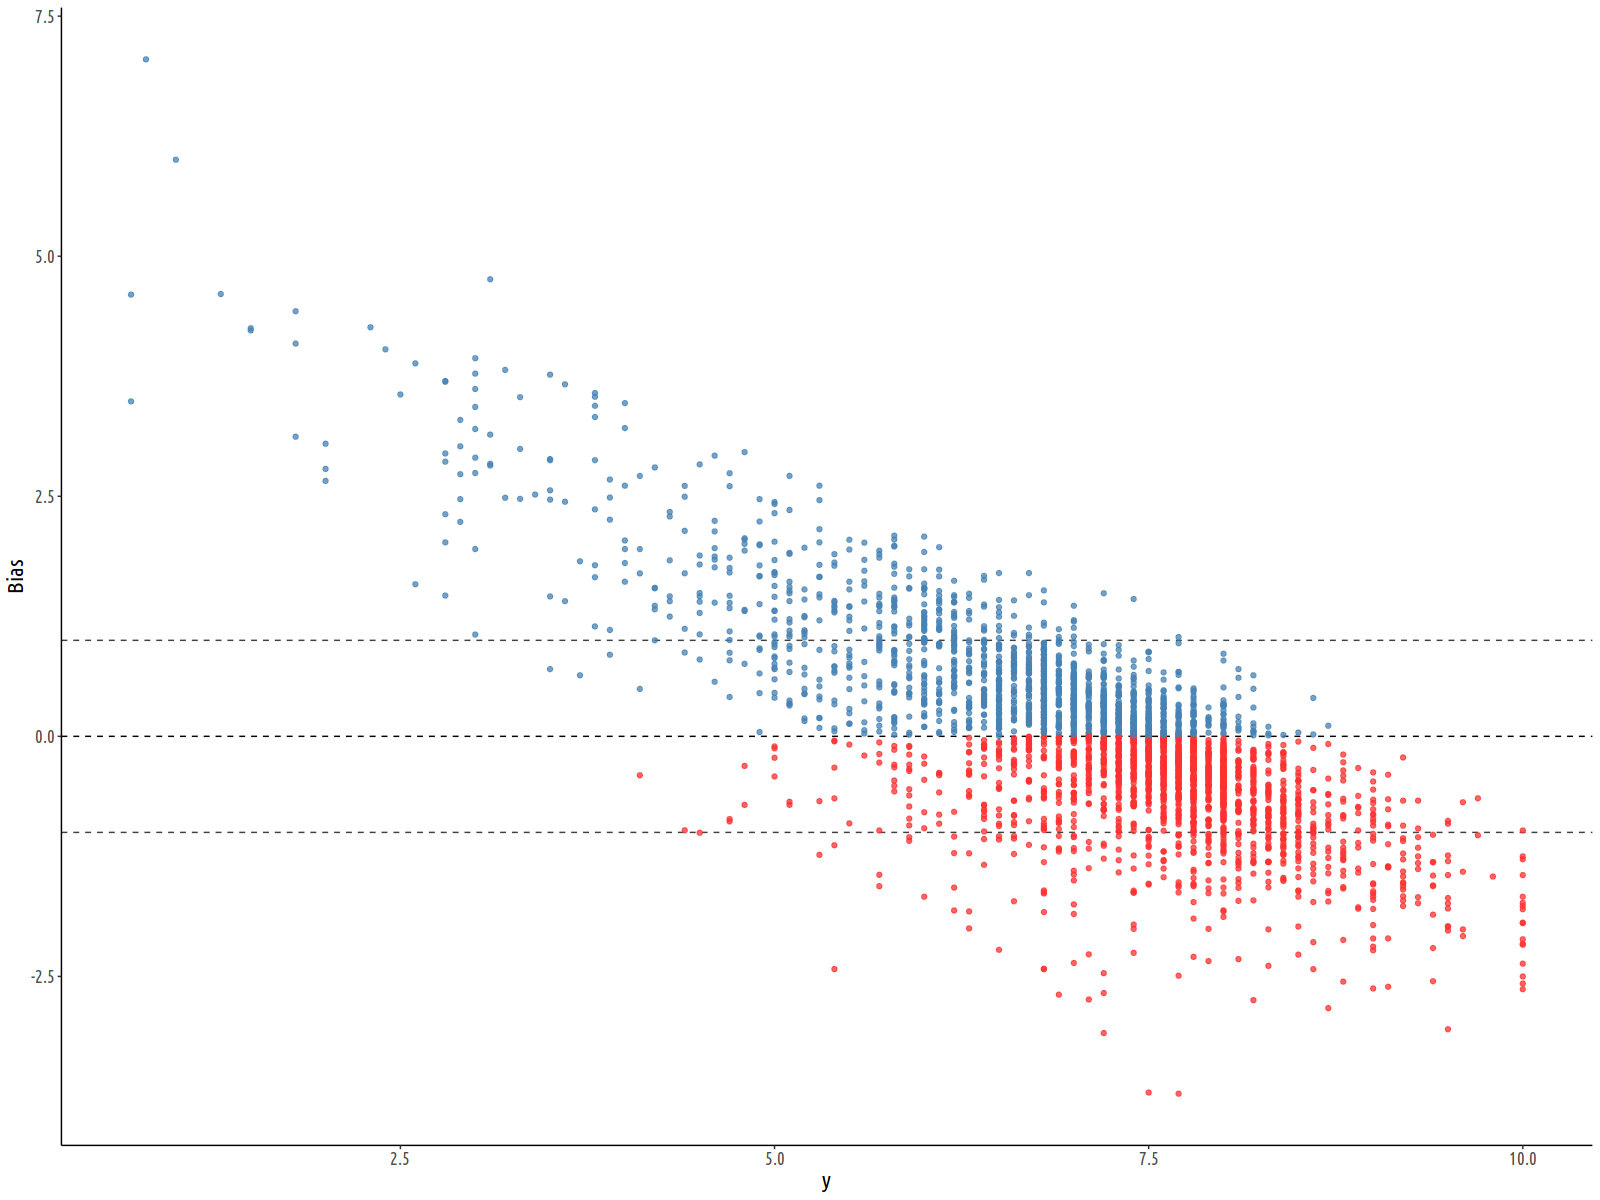

In [7]:
plt <- error_df %>%
    mutate(
        sign = as_factor(ifelse(bias > 0, "pos", "neg")),
    ) %>%
    ggplot() +
    geom_hline(aes(yintercept = 0.0), linetype = "dashed", color = "gray0") +
    geom_hline(aes(yintercept = -1.0), linetype = "dashed", color = "gray25") +
    geom_hline(aes(yintercept = 1.0), linetype = "dashed", color = "gray25") +
    geom_point(aes(x = y, y = bias, color = sign), alpha = 0.75) +
    scale_color_manual(values = sign_colors)

plt <- plt %>%
    set_theme_elements() +
    guides(color = "none") +
    xlab("y") +
    ylab("Bias")

plt

This is a lot to take in. While it appears that there is (very) high bias for small $y$, this is much less bad the closer we get to the more common values of $y$. However, the points tend to overlap where there is a high density of observations. Let's try a different approach where we can get a better sense of the overall behavior.

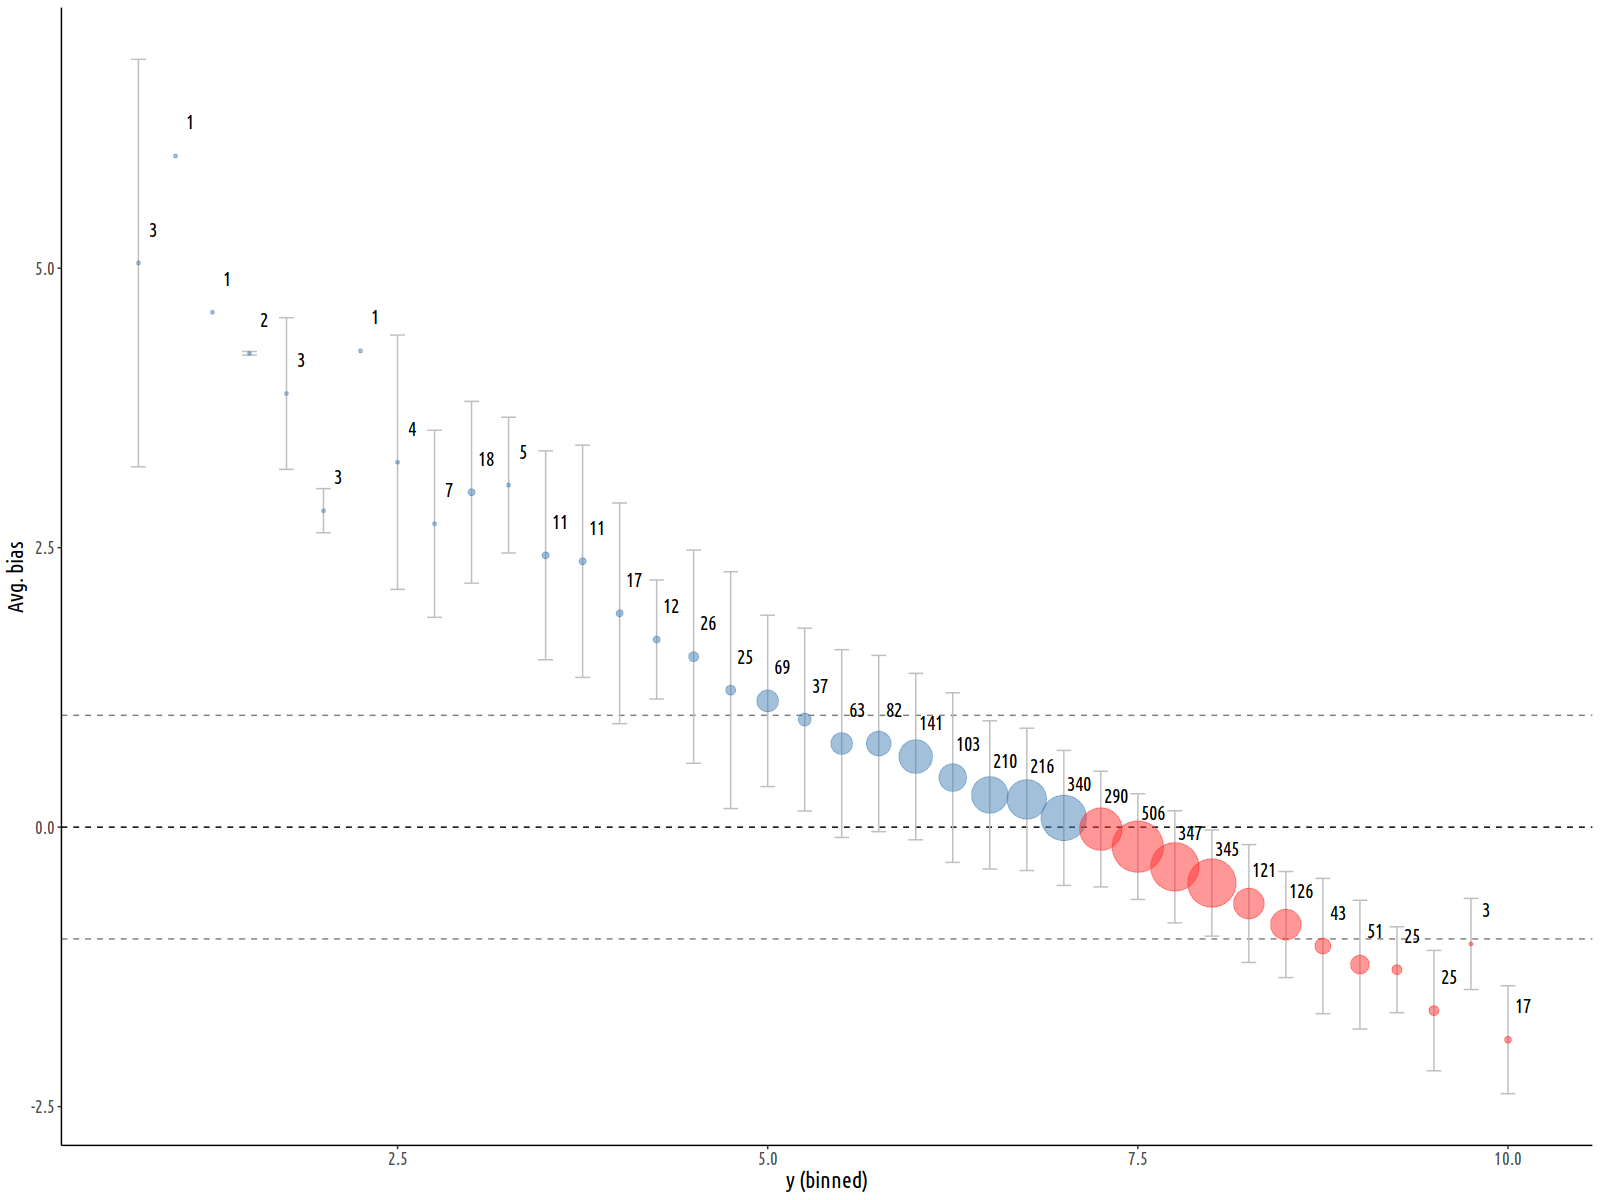

In [8]:
plt <- error_summary_df %>%
    mutate(
        sign = as_factor(ifelse(bias_mean > 0, "pos", "neg")),
        n_obs_f = cut(
            n_obs,
            breaks = size_breaks1, 
            labels = size_labels1
        )
    ) %>%
    ggplot() +
    geom_hline(aes(yintercept = 0.0), linetype = "dashed", color = "gray0") +
    geom_hline(aes(yintercept = -1.0), linetype = "dashed", color = "gray50") +
    geom_hline(aes(yintercept = 1.0), linetype = "dashed", color = "gray50") +
    geom_errorbar(aes(x = y_rnd, ymin = bias_mean - bias_sd, ymax = bias_mean + bias_sd), width = 0.1, color = "gray75") +
    geom_point(aes(x = y_rnd, y = bias_mean, size = n_obs_f, color = sign), alpha = 0.5) +
    geom_text(aes(x = y_rnd, y = bias_mean, label = as.character(n_obs)), nudge_y = 0.3, nudge_x = 0.1, size=5) +
    scale_size_manual(values = size_values1) +
    scale_color_manual(values = sign_colors)

plt <- plt %>%
    set_theme_elements() +
    guides(size = "none", color = "none") +
    xlab("y (binned)") +
    ylab("Avg. bias")

plt

In [14]:
n_row <- error_df %>% nrow()

n_row_within_1 <- error_df %>%
    filter(abs(bias) <= 1.0) %>%
    nrow()

n_row_within_2 <- error_df %>%
    filter(abs(bias) <= 2.0) %>%
    nrow()
pct_within_1 <- round((n_row_within_1 / n_row) * 100, 2)
pct_withinn_2 <- round((n_row_within_2 / n_row) * 100, 2)
print(pct_within_1)
print(pct_withinn_2)

[1] 78.55
[1] 95.56


## Baseline

What if we just guess the mean?

In [16]:
# TODO